In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split ,  GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from copy import deepcopy as dc

In [2]:
data = pd.read_excel('Nasdaq.xlsx', date_parser = True)

In [3]:
data = data[['Local Time', 'Close']]

In [4]:
data['Local Time'] = pd.to_datetime(data['Local Time'])

In [5]:
def dataframe_transform_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Local Time', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 5
transformdf = dataframe_transform_lstm(data, lookback)
transformdf

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5)
Local Time,,,,,,
2022-06-09 03:40:00,12086.271,12086.271,12086.271,12086.271,12086.271,12086.271
2022-06-09 03:35:00,12086.271,12086.271,12086.271,12086.271,12086.271,12086.271
2022-06-09 03:30:00,12086.271,12086.271,12086.271,12086.271,12086.271,12086.271
2022-06-09 03:25:00,12086.271,12086.271,12086.271,12086.271,12086.271,12086.271
2022-06-09 03:20:00,12086.271,12086.271,12086.271,12086.271,12086.271,12086.271
...,...,...,...,...,...,...
2021-06-09 17:55:00,13949.599,13971.104,13962.716,13958.930,13950.386,13941.382
2021-06-09 17:50:00,13977.323,13949.599,13971.104,13962.716,13958.930,13950.386
2021-06-09 17:45:00,13983.740,13977.323,13949.599,13971.104,13962.716,13958.930


In [6]:
transformdf_np = transformdf.to_numpy()
transformdf_np

array([[12086.271, 12086.271, 12086.271, 12086.271, 12086.271, 12086.271],
       [12086.271, 12086.271, 12086.271, 12086.271, 12086.271, 12086.271],
       [12086.271, 12086.271, 12086.271, 12086.271, 12086.271, 12086.271],
       ...,
       [13983.74 , 13977.323, 13949.599, 13971.104, 13962.716, 13958.93 ],
       [13979.654, 13983.74 , 13977.323, 13949.599, 13971.104, 13962.716],
       [13977.243, 13979.654, 13983.74 , 13977.323, 13949.599, 13971.104]])

In [7]:
scaler = StandardScaler()
transformdf_np = scaler.fit_transform(transformdf_np)

In [8]:
X = transformdf_np[:, 1:]
y = transformdf_np[:, 0]

X.shape, y.shape

((32002, 5), (32002,))

In [9]:
X = dc(np.flip(X, axis=1))
X

array([[-1.92582156, -1.92598093, -1.92614151, -1.92630238, -1.92646311],
       [-1.92582156, -1.92598093, -1.92614151, -1.92630238, -1.92646311],
       [-1.92582156, -1.92598093, -1.92614151, -1.92630238, -1.92646311],
       ...,
       [-0.29873211, -0.29550986, -0.2882891 , -0.30704512, -0.28302007],
       [-0.29544258, -0.2882214 , -0.30697617, -0.28295259, -0.27744329],
       [-0.28815453, -0.30690742, -0.28288501, -0.27737613, -0.28099428]])

In [10]:
split_index = int(len(X) * 0.95)

split_index

30401

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((30401, 5), (1601, 5), (30401,), (1601,))

In [12]:
svr = SVR()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1,0.2,1,2,3,4,5,6,7,8,9,10],
    'gamma': ['scale','auto'] + [0.01, 0.1, 1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

In [13]:
best_params = grid_search.best_params_

In [14]:
best_svr = SVR(**best_params)
best_svr.fit(X_train, y_train)

SVR(C=10, gamma=0.01)

In [15]:
y_pred = best_svr.predict(X_test)
y_pred_train=best_svr.predict(X_train)

## Perfomance Metrics of Testing Data

In [16]:
mean_squared_error(y_test, y_pred)

0.00038175168230647976

In [17]:
math.sqrt(mean_squared_error(y_test,y_pred))

0.01953846673376598

In [18]:
r2_score(y_test, y_pred)

0.9693919982713001

## Perfomance Metrics of Training Data

In [19]:
mean_squared_error(y_train, y_pred_train)

0.0006669025289275933

In [20]:
math.sqrt(mean_squared_error(y_train, y_pred_train))

0.025824456023846722

In [21]:
r2_score(y_train, y_pred_train)

0.9993653473830835

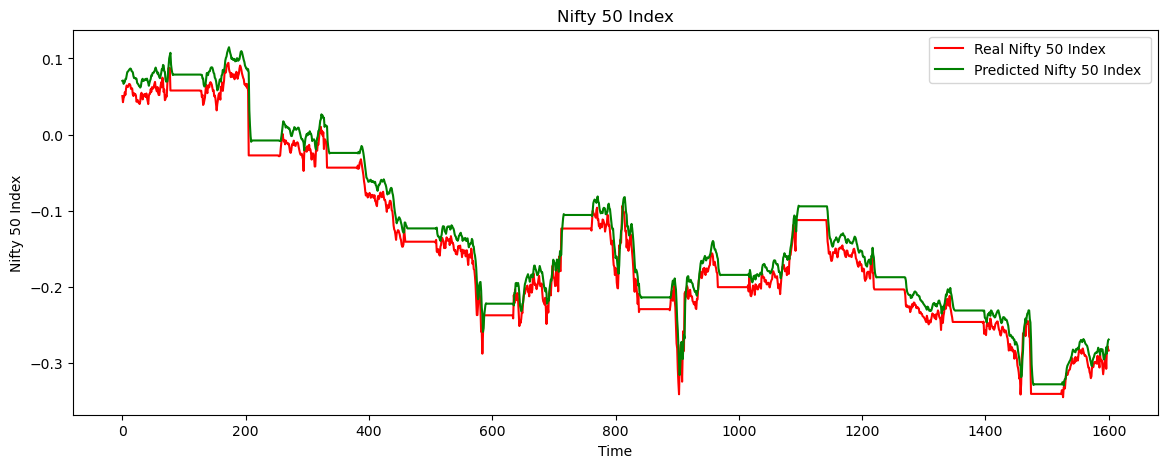

In [22]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Nifty 50 Index ')
plt.plot(y_pred, color = 'green', label = 'Predicted Nifty 50 Index ')
plt.title('Nifty 50 Index')
plt.xlabel('Time')
plt.ylabel('Nifty 50 Index')
plt.legend()
plt.show()